## **Analysis of the interaction of companies stocks and commodities**







In [ ]:
pip install yfinance

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.7 MB/s eta 0:00:00


# **Data Collection**

importing data from yahoo finance

In [ ]:
import yfinance as yf
import pandas as pd

start_date = '2020-01-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date)


all_dates_df = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=['Date'])
all_dates_df['Date'] = pd.to_datetime(all_dates_df['Date']).dt.date

ticker_symbols = ['TSLA', 'JNJ', 'JPM', 'XOM', 'DUK', 'VZ', 'DOW']

all_dates_tickers = pd.MultiIndex.from_product([all_dates_df['Date'], ticker_symbols], names=['Date', 'Ticker']).to_frame(index=False)

print(all_dates_tickers)

             Date Ticker
0      2020-01-01   TSLA
1      2020-01-01    JNJ
2      2020-01-01    JPM
3      2020-01-01    XOM
4      2020-01-01    DUK
...           ...    ...
10222  2023-12-31    JPM
10223  2023-12-31    XOM
10224  2023-12-31    DUK
10225  2023-12-31     VZ
10226  2023-12-31    DOW

[10227 rows x 2 columns]


In [ ]:



ticker_symbol = 'AAPL'

ticker_data = yf.Ticker(ticker_symbol)

start_date = '2023-01-01'
end_date = '2023-12-31'
apple_ds = ticker_data.history(start=start_date, end=end_date)


apple_ds = apple_ds.reset_index()


apple_ds['Ticker'] = ticker_symbol
apple_ds = apple_ds[['Date', 'Ticker', 'Close']]


apple_ds.to_csv(f'{ticker_symbol}_historical_data.csv', index=False)

print(f'Historical data for {ticker_symbol} has been saved to {ticker_symbol}_historical_data.csv')
print(apple_ds)


Historical data for AAPL has been saved to AAPL_historical_data.csv
                         Date Ticker       Close
0   2023-01-03 00:00:00-05:00   AAPL  123.904633
1   2023-01-04 00:00:00-05:00   AAPL  125.182610
2   2023-01-05 00:00:00-05:00   AAPL  123.855087
3   2023-01-06 00:00:00-05:00   AAPL  128.412216
4   2023-01-09 00:00:00-05:00   AAPL  128.937302
..                        ...    ...         ...
245 2023-12-22 00:00:00-05:00   AAPL  192.868134
246 2023-12-26 00:00:00-05:00   AAPL  192.320221
247 2023-12-27 00:00:00-05:00   AAPL  192.419830
248 2023-12-28 00:00:00-05:00   AAPL  192.848221
249 2023-12-29 00:00:00-05:00   AAPL  191.802185

[250 rows x 3 columns]


Companies Stocks data

In [ ]:
ticker_symbols = ['AAPL', 'TSLA', 'JNJ', 'JPM', 'XOM', 'DUK', 'GE', 'VZ', 'DOW']

combined_data = pd.DataFrame()

for ticker_symbol in ticker_symbols:
    ticker_data = yf.Ticker(ticker_symbol)

    start_date = '2020-01-01'
    end_date = '2023-12-31'
    company_data = ticker_data.history(start=start_date, end=end_date)

    company_data = company_data.reset_index()

    company_data['Ticker'] = ticker_symbol

    company_data = company_data[['Date', 'Ticker', 'Close']]

    combined_data = pd.concat([combined_data, company_data], ignore_index=True)

combined_data.to_csv('combined_historical_data.csv', index=False)

print(f'Combined historical data has been saved to combined_historical_data.csv')


combined_data['Date'] = pd.to_datetime(combined_data['Date']).dt.date

print(combined_data)

Combined historical data has been saved to combined_historical_data.csv
            Date Ticker      Close
0     2020-01-02   AAPL  72.876106
1     2020-01-03   AAPL  72.167610
2     2020-01-06   AAPL  72.742653
3     2020-01-07   AAPL  72.400543
4     2020-01-08   AAPL  73.565193
...          ...    ...        ...
9049  2023-12-22    DOW  53.071522
9050  2023-12-26    DOW  53.639595
9051  2023-12-27    DOW  53.639595
9052  2023-12-28    DOW  53.177437
9053  2023-12-29    DOW  52.801929

[9054 rows x 3 columns]


In [ ]:
data = pd.merge(all_dates_tickers, combined_data, on=['Date', 'Ticker'], how='left')
data
print(data)


             Date Ticker  Close
0      2020-01-01   TSLA    NaN
1      2020-01-01    JNJ    NaN
2      2020-01-01    JPM    NaN
3      2020-01-01    XOM    NaN
4      2020-01-01    DUK    NaN
...           ...    ...    ...
10222  2023-12-31    JPM    NaN
10223  2023-12-31    XOM    NaN
10224  2023-12-31    DUK    NaN
10225  2023-12-31     VZ    NaN
10226  2023-12-31    DOW    NaN

[10227 rows x 3 columns]


In [ ]:
print(data.isnull().sum())

Date         0
Ticker       0
Close     3185
dtype: int64


In [ ]:
interpolated_prices = pd.Series(data=[], name="Close", dtype=float)
for ticker_symbol in ticker_symbols:
  interpolated_prices = pd.concat([interpolated_prices, data[data["Ticker"] == ticker_symbol]["Close"].interpolate().bfill().ffill()])

In [ ]:
data["Close"] = interpolated_prices.sort_index()

In [ ]:
print(data.isnull().sum())

Date      0
Ticker    0
Close     0
dtype: int64


In [ ]:
commodities = {
    'WTI Crude': 'CL=F',
    'Gold': 'GC=F',
    'Natural Gas':  'NG=F',
    'Dollar': 'DX-Y.NYB'
}

commodities_data = pd.DataFrame()

for name, ticker in commodities.items():
    commodity_data = yf.Ticker(ticker).history(start='2020-01-01', end='2023-12-31')
    commodity_data = commodity_data[['Close']].rename(columns={'Close': f'{name}_Close'})
    commodity_data.reset_index(inplace=True)

    if commodities_data.empty:
        commodities_data = commodity_data
    else:
        commodities_data = pd.merge(commodities_data, commodity_data, on='Date', how='outer')

print(commodities_data.head())

                       Date  WTI Crude_Close   Gold_Close  Natural Gas_Close  \
0 2020-01-02 00:00:00-05:00        61.180000  1524.500000              2.122   
1 2020-01-03 00:00:00-05:00        63.049999  1549.199951              2.130   
2 2020-01-06 00:00:00-05:00        63.270000  1566.199951              2.135   
3 2020-01-07 00:00:00-05:00        62.700001  1571.800049              2.162   
4 2020-01-08 00:00:00-05:00        59.610001  1557.400024              2.141   

   Dollar_Close  
0     96.849998  
1     96.839996  
2     96.669998  
3     96.980003  
4     97.300003  


In [ ]:
commodities_data['Date'] = pd.to_datetime(commodities_data['Date']).dt.date
print(commodities_data.head())

         Date  WTI Crude_Close   Gold_Close  Natural Gas_Close  Dollar_Close
0  2020-01-02        61.180000  1524.500000              2.122     96.849998
1  2020-01-03        63.049999  1549.199951              2.130     96.839996
2  2020-01-06        63.270000  1566.199951              2.135     96.669998
3  2020-01-07        62.700001  1571.800049              2.162     96.980003
4  2020-01-08        59.610001  1557.400024              2.141     97.300003


In [ ]:
start_date = '2020-01-01'
end_date = '2023-12-31'

all_dates_tickers_commodities = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=['Date'])
all_dates_tickers_commodities['Date'] = pd.to_datetime(all_dates_tickers_commodities['Date']).dt.date


print(all_dates_tickers_commodities)


            Date
0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
...          ...
1456  2023-12-27
1457  2023-12-28
1458  2023-12-29
1459  2023-12-30
1460  2023-12-31

[1461 rows x 1 columns]


In [ ]:

commodities_dataset = pd.merge(all_dates_tickers_commodities, commodities_data, on='Date', how='left')

print(commodities_dataset)

commodities_dataset.to_csv('ds3.csv', index=False)

            Date  WTI Crude_Close   Gold_Close  Natural Gas_Close  \
0     2020-01-01              NaN          NaN                NaN   
1     2020-01-02        61.180000  1524.500000              2.122   
2     2020-01-03        63.049999  1549.199951              2.130   
3     2020-01-04              NaN          NaN                NaN   
4     2020-01-05              NaN          NaN                NaN   
...          ...              ...          ...                ...   
1456  2023-12-27        74.110001  2081.899902              2.619   
1457  2023-12-28        71.769997  2073.899902              2.557   
1458  2023-12-29        71.650002  2062.399902              2.514   
1459  2023-12-30              NaN          NaN                NaN   
1460  2023-12-31              NaN          NaN                NaN   

      Dollar_Close  
0              NaN  
1        96.849998  
2        96.839996  
3              NaN  
4              NaN  
...            ...  
1456    100.989998  
145

In [ ]:
commodities_dataset.isnull().sum()

,0
Date,0
WTI Crude_Close,455
Gold_Close,455
Natural Gas_Close,454
Dollar_Close,455


In [ ]:
commodity_columns = ['WTI Crude_Close', 'Gold_Close', 'Natural Gas_Close', 'Dollar_Close']

commodities_dataset['Date'] = pd.to_datetime(commodities_dataset['Date'])

for col in commodity_columns:
    commodities_dataset[col] = commodities_dataset[col].interpolate().bfill().ffill()

commodities_dataset = commodities_dataset.reset_index(drop=True)


print(commodities_dataset.isnull().sum())


Date                 0
WTI Crude_Close      0
Gold_Close           0
Natural Gas_Close    0
Dollar_Close         0
dtype: int64


In [ ]:
commodities_dataset

,Date,WTI Crude_Close,Gold_Close,Natural Gas_Close,Dollar_Close
0,2020-01-01,61.180000,1524.500000,2.122000,96.849998
1,2020-01-02,61.180000,1524.500000,2.122000,96.849998
2,2020-01-03,63.049999,1549.199951,2.130000,96.839996
3,2020-01-04,63.123333,1554.866618,2.131667,96.783330
4,2020-01-05,63.196667,1560.533285,2.133333,96.726664
...,...,...,...,...,...
1456,2023-12-27,74.110001,2081.899902,2.619000,100.989998
1457,2023-12-28,71.769997,2073.899902,2.557000,101.230003
1458,2023-12-29,71.650002,2062.399902,2.514000,101.330002
1459,2023-12-30,71.650002,2062.399902,2.514000,101.330002


Merge datasets by date

In [ ]:
data['Date'] = pd.to_datetime(data['Date']).dt.date
commodities_dataset['Date'] = pd.to_datetime(commodities_dataset['Date']).dt.date

final_dataset = pd.merge(data, commodities_dataset, on='Date', how='left')

print(final_dataset)

final_dataset.isnull().sum()
final_dataset.to_csv(f'ds.csv', index=False)

             Date Ticker       Close  WTI Crude_Close   Gold_Close  \
0      2020-01-01   TSLA   28.684000        61.180000  1524.500000   
1      2020-01-01    JNJ  128.083694        61.180000  1524.500000   
2      2020-01-01    JPM  122.852890        61.180000  1524.500000   
3      2020-01-01    XOM   56.088299        61.180000  1524.500000   
4      2020-01-01    DUK   74.428658        61.180000  1524.500000   
...           ...    ...         ...              ...          ...   
10222  2023-12-31    JPM  167.150925        71.650002  2062.399902   
10223  2023-12-31    XOM   97.476486        71.650002  2062.399902   
10224  2023-12-31    DUK   94.121735        71.650002  2062.399902   
10225  2023-12-31     VZ   35.896526        71.650002  2062.399902   
10226  2023-12-31    DOW   52.801929        71.650002  2062.399902   

       Natural Gas_Close  Dollar_Close  
0                  2.122     96.849998  
1                  2.122     96.849998  
2                  2.122     96.8499

In [ ]:
final_df = pd.DataFrame(final_dataset)

In [ ]:
final_df

,Date,Ticker,Close,WTI Crude_Close,Gold_Close,Natural Gas_Close,Dollar_Close
0,2020-01-01,TSLA,28.684000,61.180000,1524.500000,2.122,96.849998
1,2020-01-01,JNJ,128.083694,61.180000,1524.500000,2.122,96.849998
2,2020-01-01,JPM,122.852890,61.180000,1524.500000,2.122,96.849998
3,2020-01-01,XOM,56.088299,61.180000,1524.500000,2.122,96.849998
4,2020-01-01,DUK,74.428658,61.180000,1524.500000,2.122,96.849998
...,...,...,...,...,...,...,...
10222,2023-12-31,JPM,167.150925,71.650002,2062.399902,2.514,101.330002
10223,2023-12-31,XOM,97.476486,71.650002,2062.399902,2.514,101.330002
10224,2023-12-31,DUK,94.121735,71.650002,2062.399902,2.514,101.330002
10225,2023-12-31,VZ,35.896526,71.650002,2062.399902,2.514,101.330002


In [ ]:
final_df.isnull().sum()

,0
Date,0
Ticker,0
Close,0
WTI Crude_Close,0
Gold_Close,0
Natural Gas_Close,0
Dollar_Close,0


In [ ]:
final_df.sort_values(by=['Date', 'Ticker'], inplace=True)
final_df

,Date,Ticker,Close,WTI Crude_Close,Gold_Close,Natural Gas_Close,Dollar_Close
6,2020-01-01,DOW,42.025867,61.180000,1524.500000,2.122,96.849998
4,2020-01-01,DUK,74.428658,61.180000,1524.500000,2.122,96.849998
1,2020-01-01,JNJ,128.083694,61.180000,1524.500000,2.122,96.849998
2,2020-01-01,JPM,122.852890,61.180000,1524.500000,2.122,96.849998
0,2020-01-01,TSLA,28.684000,61.180000,1524.500000,2.122,96.849998
...,...,...,...,...,...,...,...
10221,2023-12-31,JNJ,153.149109,71.650002,2062.399902,2.514,101.330002
10222,2023-12-31,JPM,167.150925,71.650002,2062.399902,2.514,101.330002
10220,2023-12-31,TSLA,248.479996,71.650002,2062.399902,2.514,101.330002
10225,2023-12-31,VZ,35.896526,71.650002,2062.399902,2.514,101.330002


In [ ]:
final_df.to_csv(f'companies_dataset.csv', index=False)

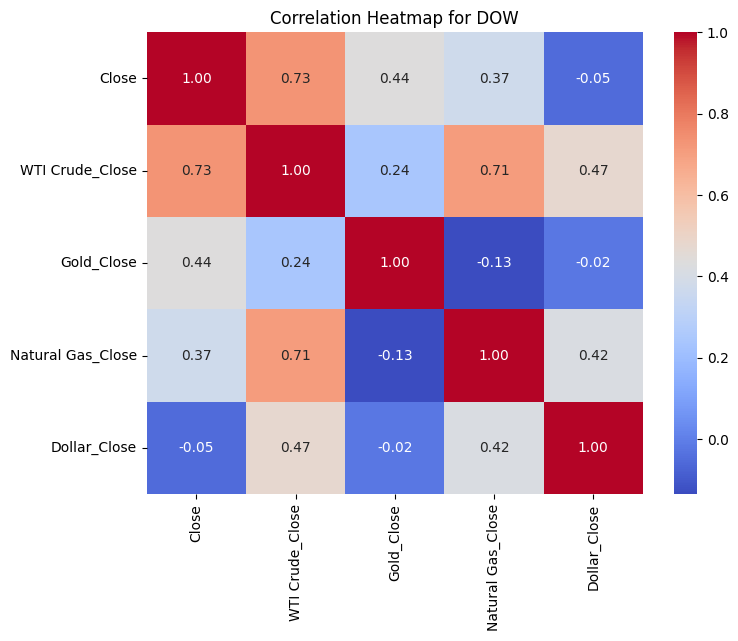

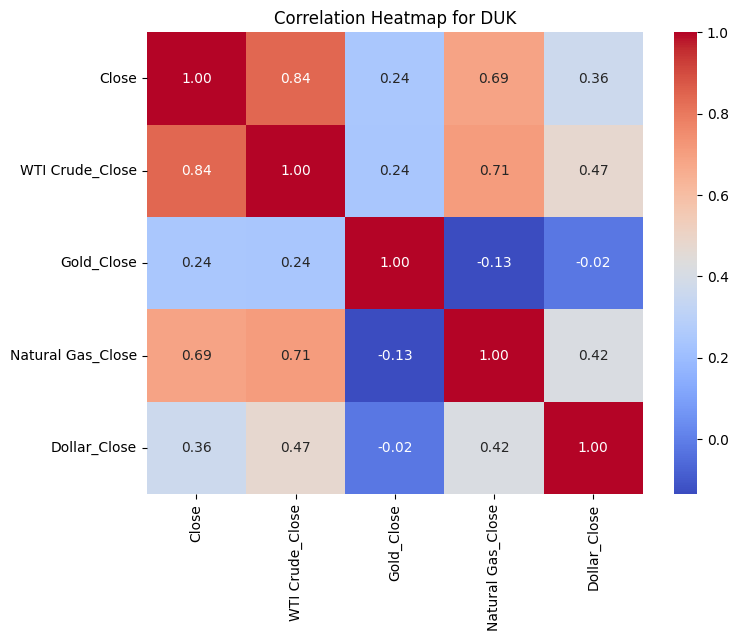

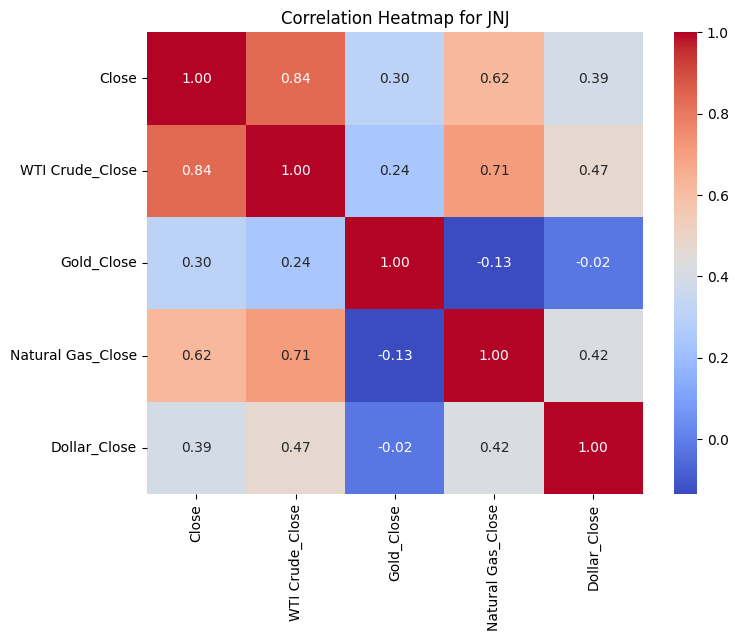

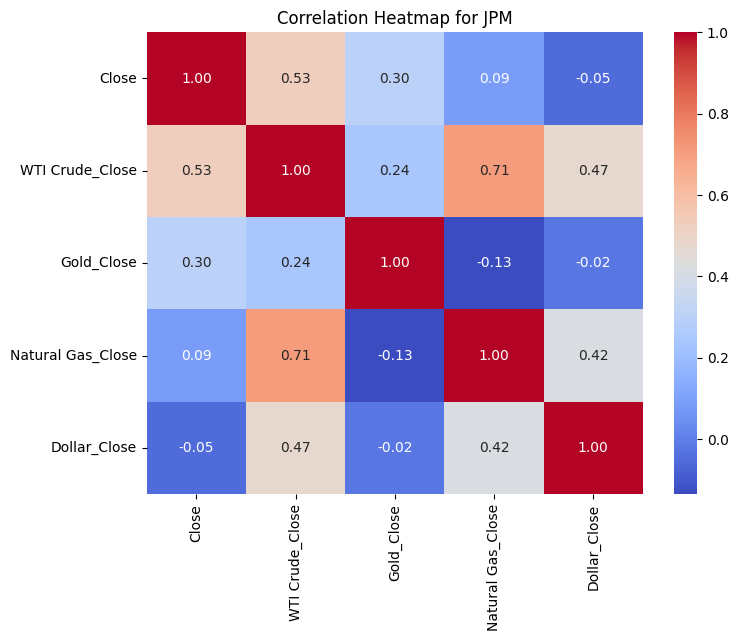

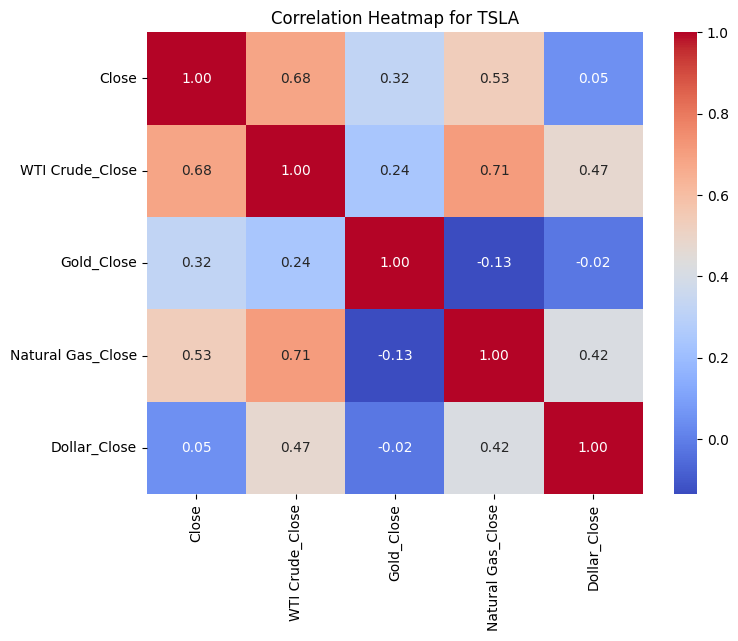

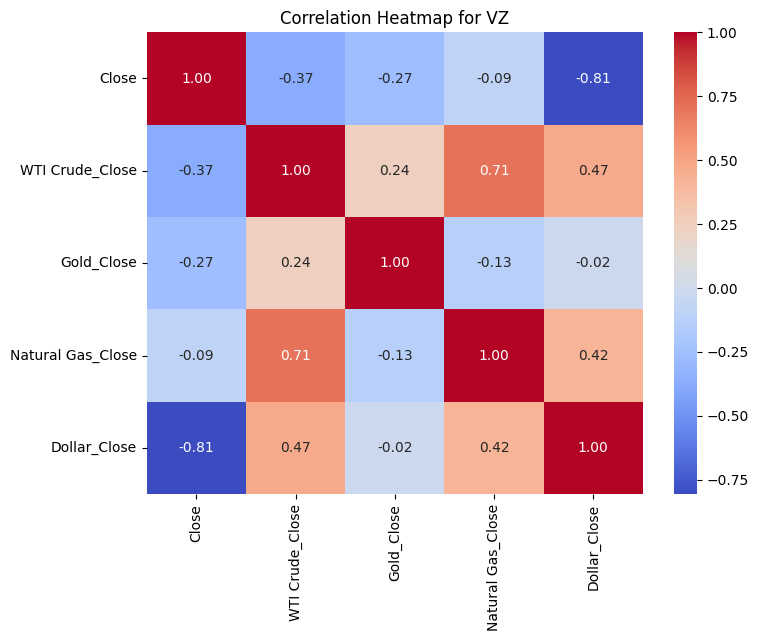

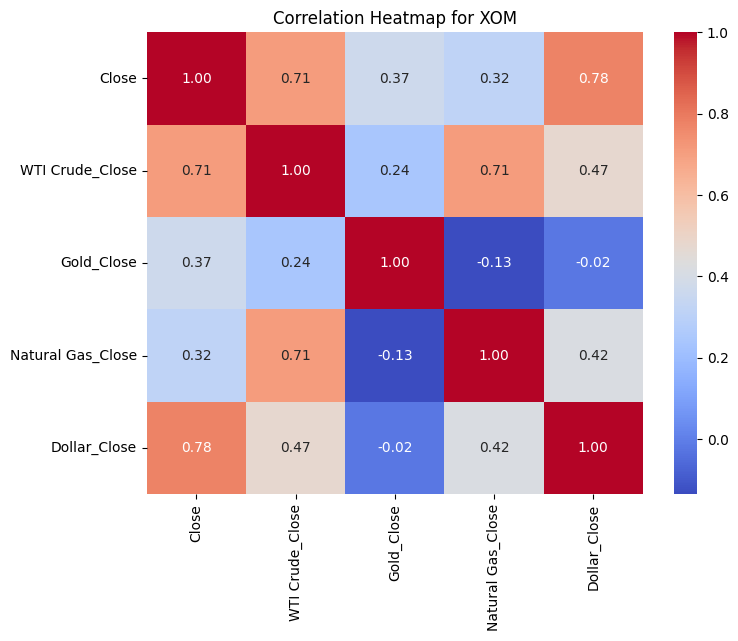

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#final_df = final_df.reset_index()

for ticker in final_df['Ticker'].unique():
    company_data = final_df[final_df['Ticker'] == ticker]

    numeric_columns = ['Close', 'WTI Crude_Close', 'Gold_Close', 'Natural Gas_Close', 'Dollar_Close']

    correlation_matrix = company_data[numeric_columns].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for {ticker}')
    plt.show()


<ipython-input-295-9d90cd27afda>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 3)
<ipython-input-295-9d90cd27afda>:33: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


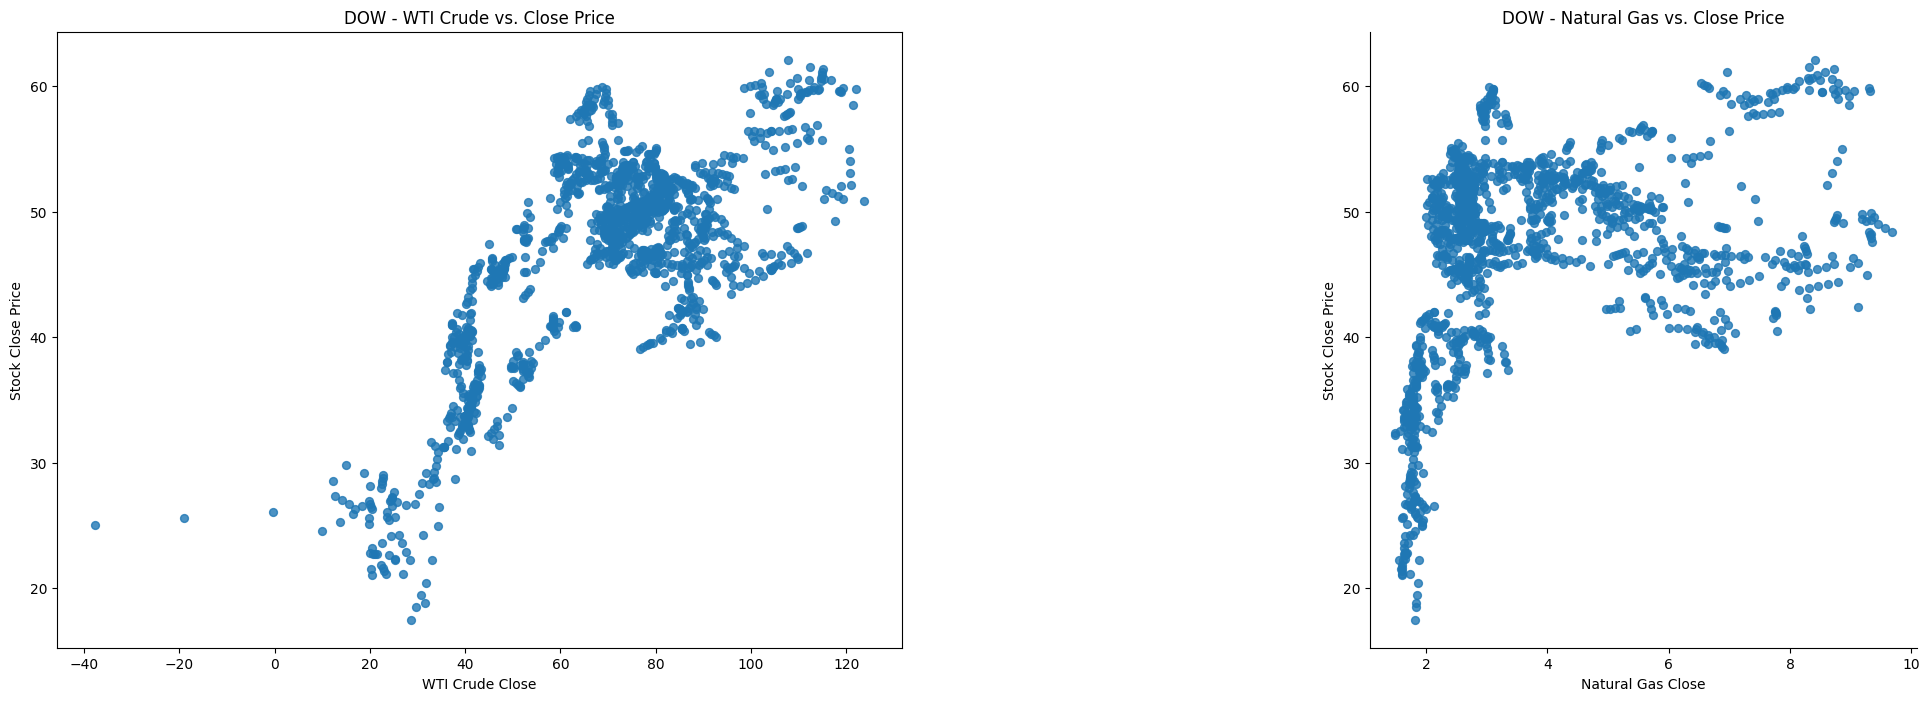

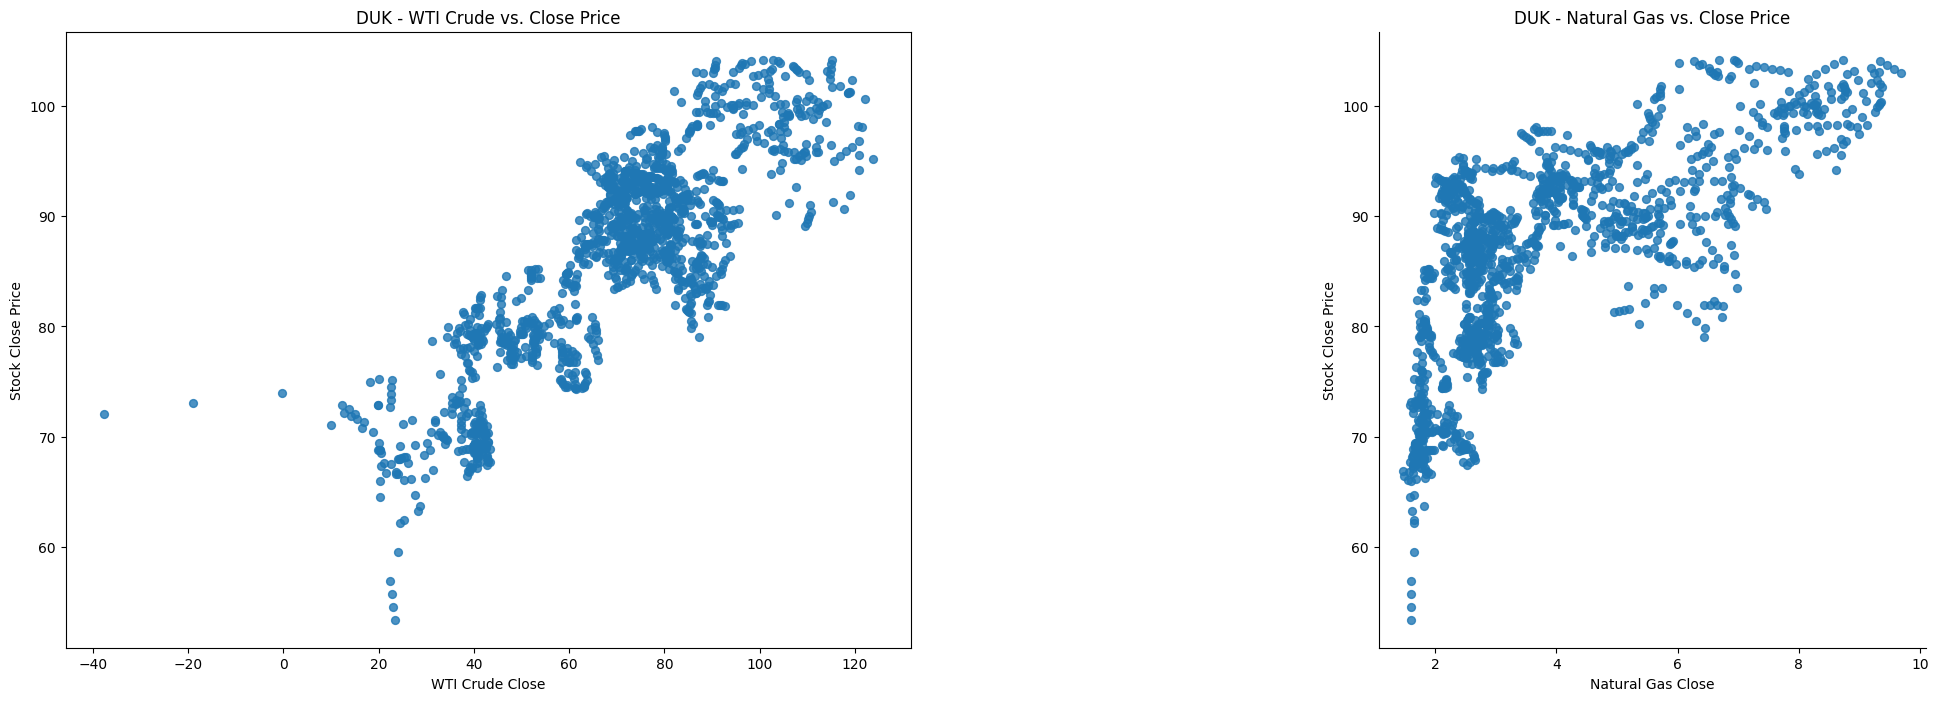

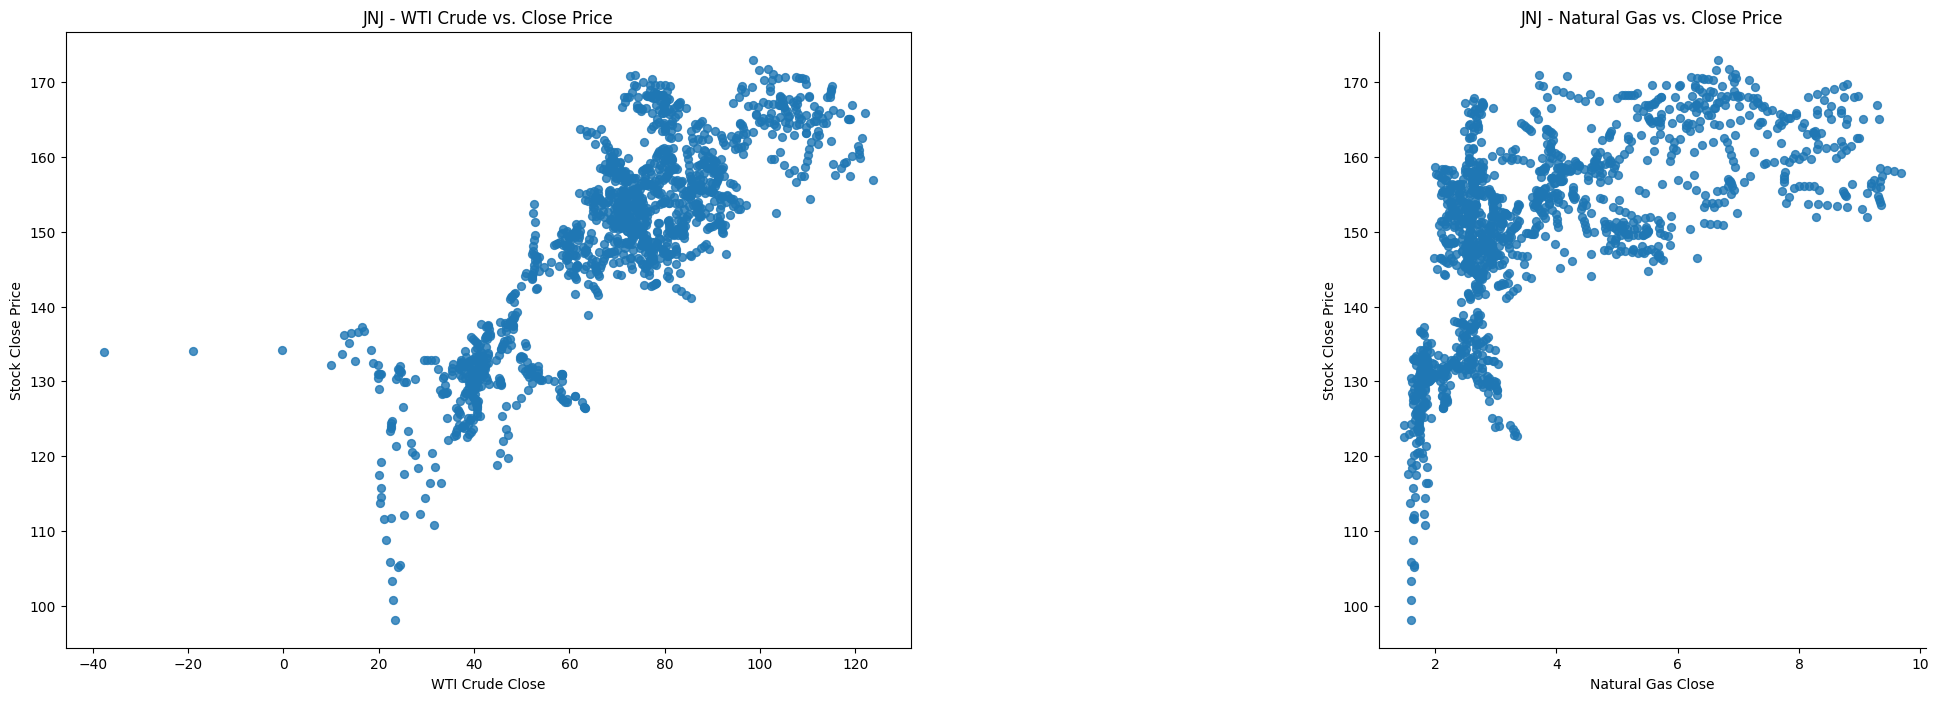

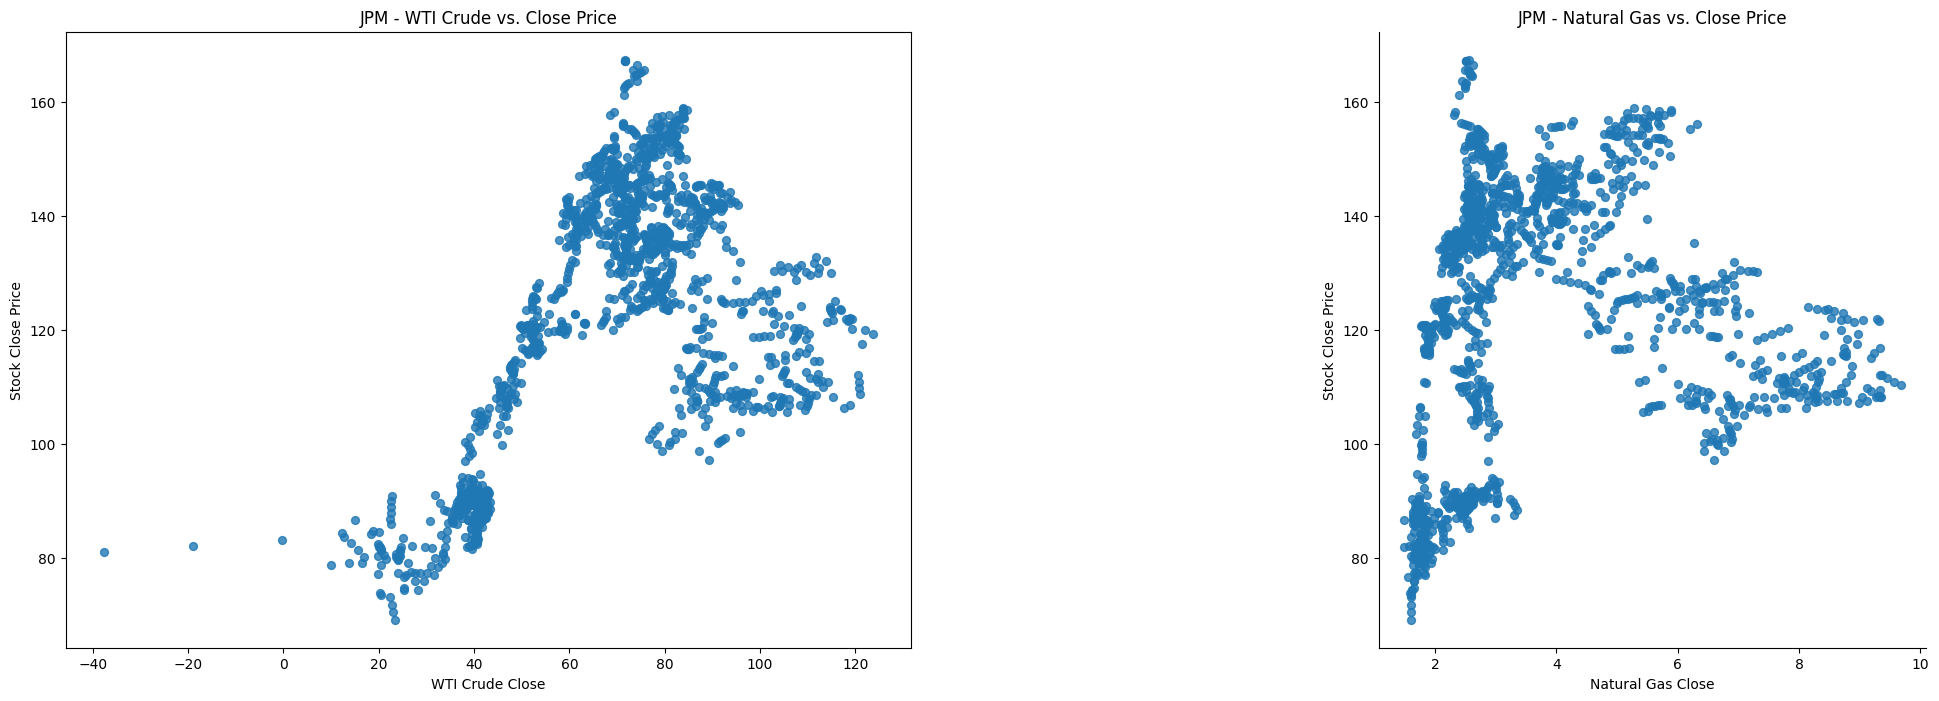

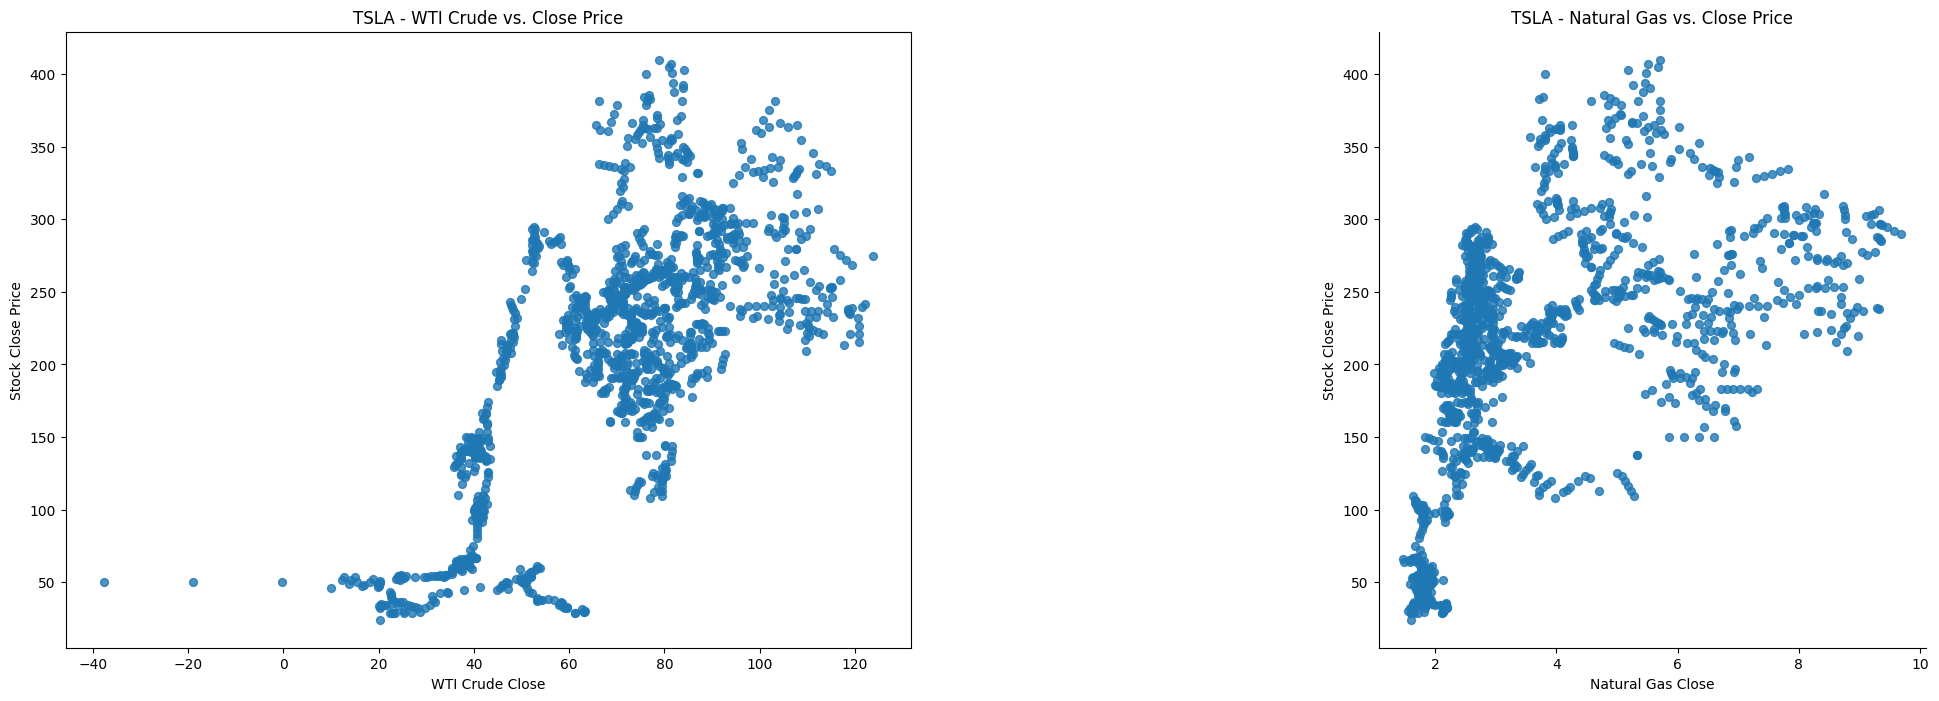

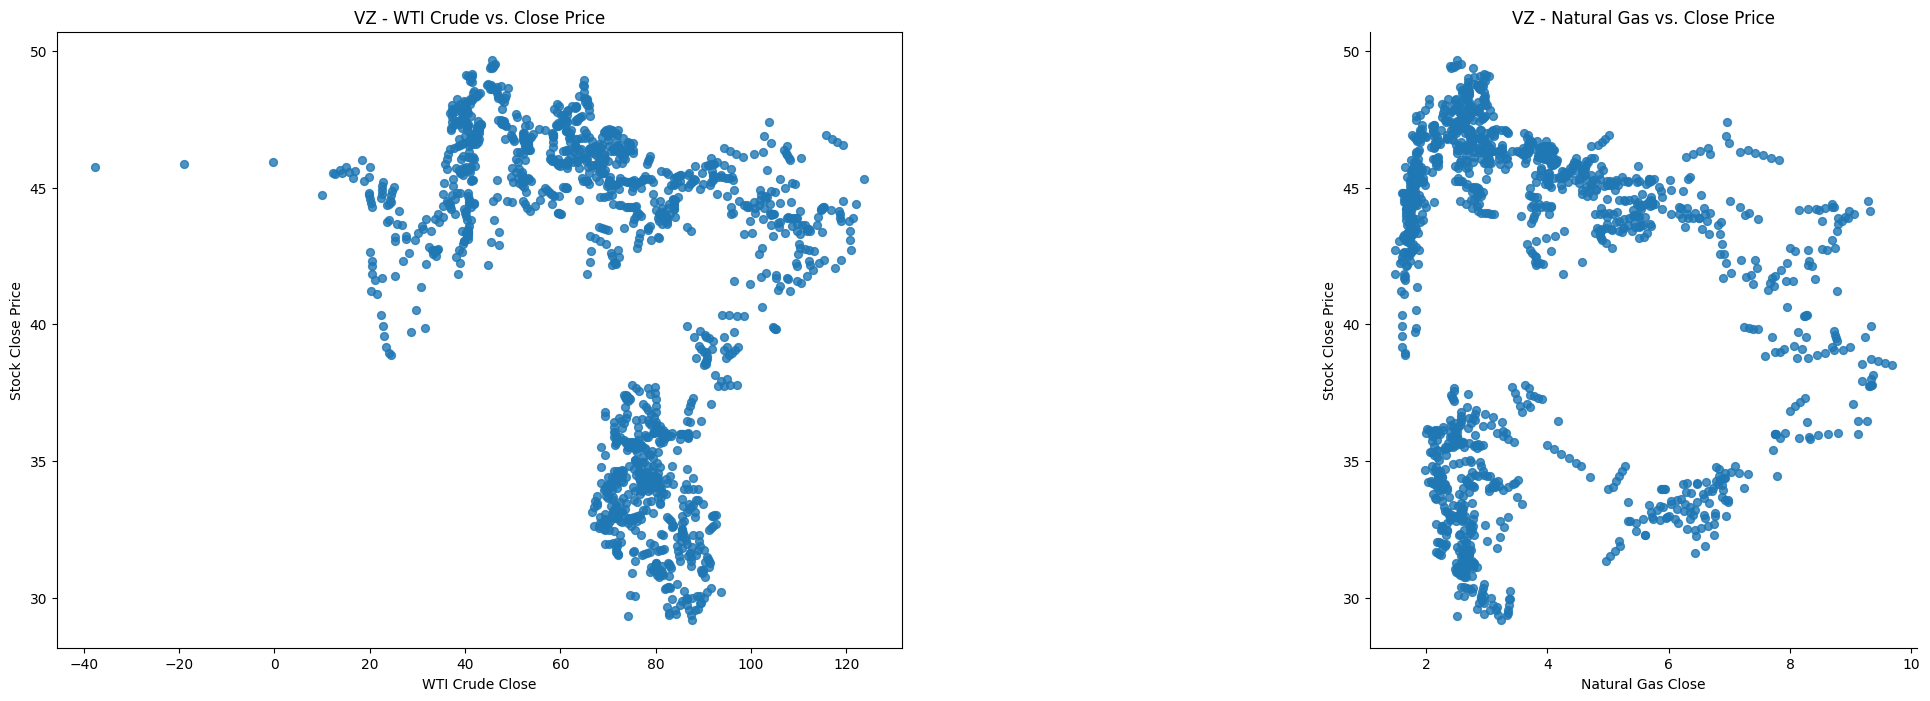

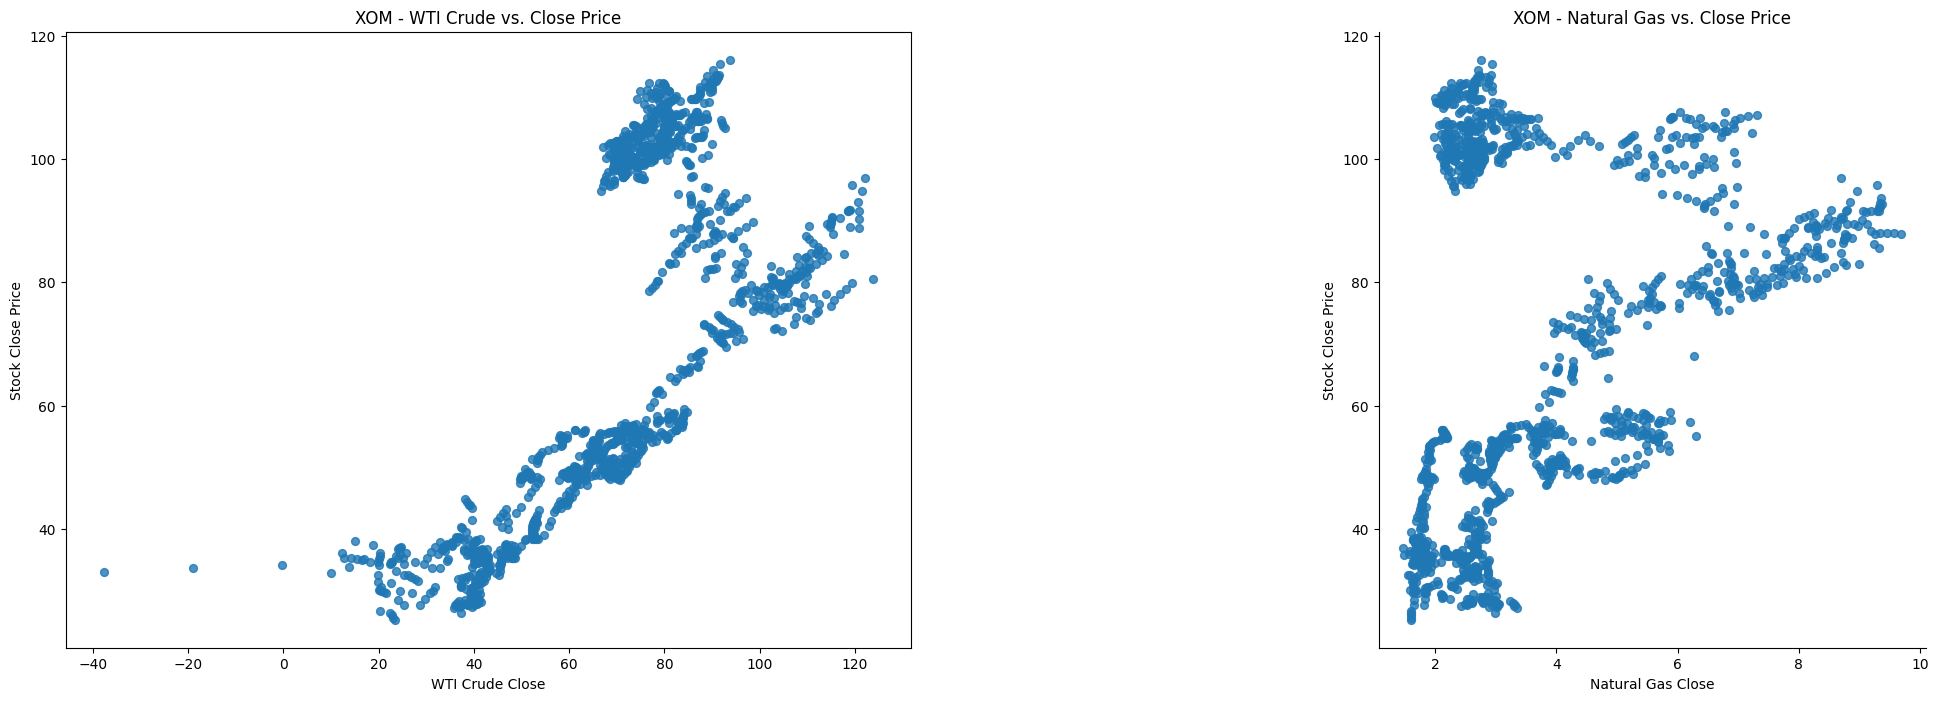

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# final_df = final_df.reset_index()

companies = final_df['Ticker'].unique()

for company in companies:
    company_df = final_df[final_df['Ticker'] == company]

    plt.figure(figsize=(24, 8))

    plt.subplot(1, 2, 1)
    plt.scatter(company_df['WTI Crude_Close'], company_df['Close'], s=32, alpha=0.8)
    plt.title(f'{company} - WTI Crude vs. Close Price')
    plt.xlabel('WTI Crude Close')
    plt.ylabel('Stock Close Price')

    plt.subplot(1, 2, 2)
    plt.scatter(company_df['Gold_Close'], company_df['Close'], s=32, alpha=0.8)
    plt.title(f'{company} - Gold vs. Close Price')
    plt.xlabel('Gold Close')
    plt.ylabel('Stock Close Price')

    plt.subplot(1, 3, 3)
    plt.scatter(company_df['Natural Gas_Close'], company_df['Close'], s=32, alpha=0.8)
    plt.title(f'{company} - Natural Gas vs. Close Price')
    plt.xlabel('Natural Gas Close')
    plt.ylabel('Stock Close Price')

    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()


# Importing **Lags**

In [ ]:
lags = 3
def create_lags(df, lags):
    """ Create lag features for each ticker """
    df_lagged = df.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'Close_Lag_{lag}'] = df_lagged.groupby('Ticker')['Close'].shift(lag)
        df_lagged[f'WTI_Crude_Lag_{lag}'] = df_lagged.groupby('Ticker')['WTI Crude_Close'].shift(lag)
        df_lagged[f'Gold_Lag_{lag}'] = df_lagged.groupby('Ticker')['Gold_Close'].shift(lag)
        df_lagged[f'Dollar_Lag_{lag}'] = df_lagged.groupby('Ticker')['Dollar_Close'].shift(lag)
    return df_lagged

df_lagged = create_lags(final_df, lags)

df_lagged = df_lagged.dropna().reset_index(drop=True)


In [ ]:
df_lagged.head()

,Date,Ticker,Close,WTI Crude_Close,Gold_Close,Natural Gas_Close,Dollar_Close,Close_Lag_1,WTI_Crude_Lag_1,Gold_Lag_1,Dollar_Lag_1,Close_Lag_2,WTI_Crude_Lag_2,Gold_Lag_2,Dollar_Lag_2,Close_Lag_3,WTI_Crude_Lag_3,Gold_Lag_3,Dollar_Lag_3
0,2020-01-04,DOW,40.931248,63.123333,1554.866618,2.131667,96.78333,40.985977,63.049999,1549.199951,96.839996,42.025867,61.18,1524.5,96.849998,42.025867,61.18,1524.5,96.849998
1,2020-01-04,DUK,74.598928,63.123333,1554.866618,2.131667,96.78333,74.478104,63.049999,1549.199951,96.839996,74.428658,61.18,1524.5,96.849998,74.428658,61.18,1524.5,96.849998
2,2020-01-04,JNJ,126.548159,63.123333,1554.866618,2.131667,96.78333,126.600807,63.049999,1549.199951,96.839996,128.083694,61.18,1524.5,96.849998,128.083694,61.18,1524.5,96.849998
3,2020-01-04,JPM,121.199506,63.123333,1554.866618,2.131667,96.78333,121.231636,63.049999,1549.199951,96.839996,122.852890,61.18,1524.5,96.849998,122.852890,61.18,1524.5,96.849998
4,2020-01-04,TSLA,29.723556,63.123333,1554.866618,2.131667,96.78333,29.534000,63.049999,1549.199951,96.839996,28.684000,61.18,1524.5,96.849998,28.684000,61.18,1524.5,96.849998


In [ ]:
#df_lagged['Close_Diff'] = df_lagged.groupby('Ticker')['Close'].diff()
#df_lagged['Close_Return'] = df_lagged.groupby('Ticker')['Close'].pct_change()
df_lagged['Gold_WTI_Spread'] = df_lagged['Gold_Close'] - df_lagged['WTI Crude_Close']


df_lagged

,Date,Ticker,Close,WTI Crude_Close,Gold_Close,Natural Gas_Close,Dollar_Close,Close_Lag_1,WTI_Crude_Lag_1,Gold_Lag_1,Dollar_Lag_1,Close_Lag_2,WTI_Crude_Lag_2,Gold_Lag_2,Dollar_Lag_2,Close_Lag_3,WTI_Crude_Lag_3,Gold_Lag_3,Dollar_Lag_3,Gold_WTI_Spread
0,2020-01-04,DOW,40.931248,63.123333,1554.866618,2.131667,96.783330,40.985977,63.049999,1549.199951,96.839996,42.025867,61.180000,1524.500000,96.849998,42.025867,61.180000,1524.500000,96.849998,1491.743285
1,2020-01-04,DUK,74.598928,63.123333,1554.866618,2.131667,96.783330,74.478104,63.049999,1549.199951,96.839996,74.428658,61.180000,1524.500000,96.849998,74.428658,61.180000,1524.500000,96.849998,1491.743285
2,2020-01-04,JNJ,126.548159,63.123333,1554.866618,2.131667,96.783330,126.600807,63.049999,1549.199951,96.839996,128.083694,61.180000,1524.500000,96.849998,128.083694,61.180000,1524.500000,96.849998,1491.743285
3,2020-01-04,JPM,121.199506,63.123333,1554.866618,2.131667,96.783330,121.231636,63.049999,1549.199951,96.839996,122.852890,61.180000,1524.500000,96.849998,122.852890,61.180000,1524.500000,96.849998,1491.743285
4,2020-01-04,TSLA,29.723556,63.123333,1554.866618,2.131667,96.783330,29.534000,63.049999,1549.199951,96.839996,28.684000,61.180000,1524.500000,96.849998,28.684000,61.180000,1524.500000,96.849998,1491.743285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,2023-12-31,JNJ,153.149109,71.650002,2062.399902,2.514000,101.330002,153.149109,71.650002,2062.399902,101.330002,153.149109,71.650002,2062.399902,101.330002,152.992767,71.769997,2073.899902,101.230003,1990.749901
10202,2023-12-31,JPM,167.150925,71.650002,2062.399902,2.514000,101.330002,167.150925,71.650002,2062.399902,101.330002,167.150925,71.650002,2062.399902,101.330002,167.347443,71.769997,2073.899902,101.230003,1990.749901
10203,2023-12-31,TSLA,248.479996,71.650002,2062.399902,2.514000,101.330002,248.479996,71.650002,2062.399902,101.330002,248.479996,71.650002,2062.399902,101.330002,253.179993,71.769997,2073.899902,101.230003,1990.749901
10204,2023-12-31,VZ,35.896526,71.650002,2062.399902,2.514000,101.330002,35.896526,71.650002,2062.399902,101.330002,35.896526,71.650002,2062.399902,101.330002,35.696579,71.769997,2073.899902,101.230003,1990.749901


In [ ]:
df = df_lagged.drop(columns=['Date', 'WTI Crude_Close', 'Gold_Close', 'Natural Gas_Close', 'Dollar_Close'])
df

,Ticker,Close,Close_Lag_1,WTI_Crude_Lag_1,Gold_Lag_1,Dollar_Lag_1,Close_Lag_2,WTI_Crude_Lag_2,Gold_Lag_2,Dollar_Lag_2,Close_Lag_3,WTI_Crude_Lag_3,Gold_Lag_3,Dollar_Lag_3,Gold_WTI_Spread
0,DOW,40.931248,40.985977,63.049999,1549.199951,96.839996,42.025867,61.180000,1524.500000,96.849998,42.025867,61.180000,1524.500000,96.849998,1491.743285
1,DUK,74.598928,74.478104,63.049999,1549.199951,96.839996,74.428658,61.180000,1524.500000,96.849998,74.428658,61.180000,1524.500000,96.849998,1491.743285
2,JNJ,126.548159,126.600807,63.049999,1549.199951,96.839996,128.083694,61.180000,1524.500000,96.849998,128.083694,61.180000,1524.500000,96.849998,1491.743285
3,JPM,121.199506,121.231636,63.049999,1549.199951,96.839996,122.852890,61.180000,1524.500000,96.849998,122.852890,61.180000,1524.500000,96.849998,1491.743285
4,TSLA,29.723556,29.534000,63.049999,1549.199951,96.839996,28.684000,61.180000,1524.500000,96.849998,28.684000,61.180000,1524.500000,96.849998,1491.743285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,JNJ,153.149109,153.149109,71.650002,2062.399902,101.330002,153.149109,71.650002,2062.399902,101.330002,152.992767,71.769997,2073.899902,101.230003,1990.749901
10202,JPM,167.150925,167.150925,71.650002,2062.399902,101.330002,167.150925,71.650002,2062.399902,101.330002,167.347443,71.769997,2073.899902,101.230003,1990.749901
10203,TSLA,248.479996,248.479996,71.650002,2062.399902,101.330002,248.479996,71.650002,2062.399902,101.330002,253.179993,71.769997,2073.899902,101.230003,1990.749901
10204,VZ,35.896526,35.896526,71.650002,2062.399902,101.330002,35.896526,71.650002,2062.399902,101.330002,35.696579,71.769997,2073.899902,101.230003,1990.749901


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Ticker'] = label_encoder.fit_transform(df['Ticker'])


In [ ]:
company_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(company_mapping)

{'DOW': 0, 'DUK': 1, 'JNJ': 2, 'JPM': 3, 'TSLA': 4, 'VZ': 5, 'XOM': 6}


In [ ]:
ticker_mapping = {v: k for k, v in company_mapping.items()}

In [ ]:
ticker_mapping

{0: 'DOW', 1: 'DUK', 2: 'JNJ', 3: 'JPM', 4: 'TSLA', 5: 'VZ', 6: 'XOM'}

In [ ]:
df

,Ticker,Close,Close_Lag_1,WTI_Crude_Lag_1,Gold_Lag_1,Dollar_Lag_1,Close_Lag_2,WTI_Crude_Lag_2,Gold_Lag_2,Dollar_Lag_2,Close_Lag_3,WTI_Crude_Lag_3,Gold_Lag_3,Dollar_Lag_3,Gold_WTI_Spread
0,0,40.931248,40.985977,63.049999,1549.199951,96.839996,42.025867,61.180000,1524.500000,96.849998,42.025867,61.180000,1524.500000,96.849998,1491.743285
1,1,74.598928,74.478104,63.049999,1549.199951,96.839996,74.428658,61.180000,1524.500000,96.849998,74.428658,61.180000,1524.500000,96.849998,1491.743285
2,2,126.548159,126.600807,63.049999,1549.199951,96.839996,128.083694,61.180000,1524.500000,96.849998,128.083694,61.180000,1524.500000,96.849998,1491.743285
3,3,121.199506,121.231636,63.049999,1549.199951,96.839996,122.852890,61.180000,1524.500000,96.849998,122.852890,61.180000,1524.500000,96.849998,1491.743285
4,4,29.723556,29.534000,63.049999,1549.199951,96.839996,28.684000,61.180000,1524.500000,96.849998,28.684000,61.180000,1524.500000,96.849998,1491.743285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,2,153.149109,153.149109,71.650002,2062.399902,101.330002,153.149109,71.650002,2062.399902,101.330002,152.992767,71.769997,2073.899902,101.230003,1990.749901
10202,3,167.150925,167.150925,71.650002,2062.399902,101.330002,167.150925,71.650002,2062.399902,101.330002,167.347443,71.769997,2073.899902,101.230003,1990.749901
10203,4,248.479996,248.479996,71.650002,2062.399902,101.330002,248.479996,71.650002,2062.399902,101.330002,253.179993,71.769997,2073.899902,101.230003,1990.749901
10204,5,35.896526,35.896526,71.650002,2062.399902,101.330002,35.896526,71.650002,2062.399902,101.330002,35.696579,71.769997,2073.899902,101.230003,1990.749901


# **XGBoost**

Company DOW MSE: 0.66, R²: 0.82


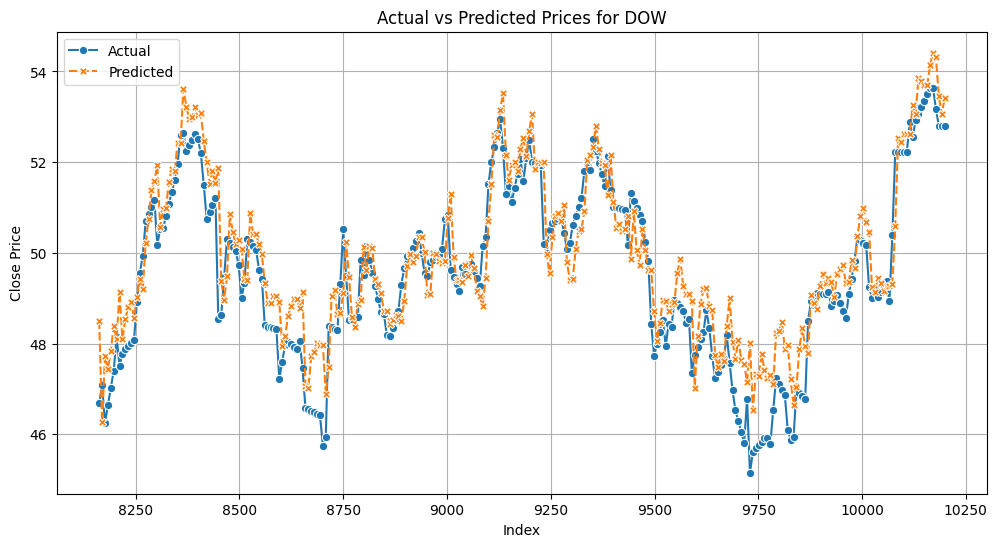

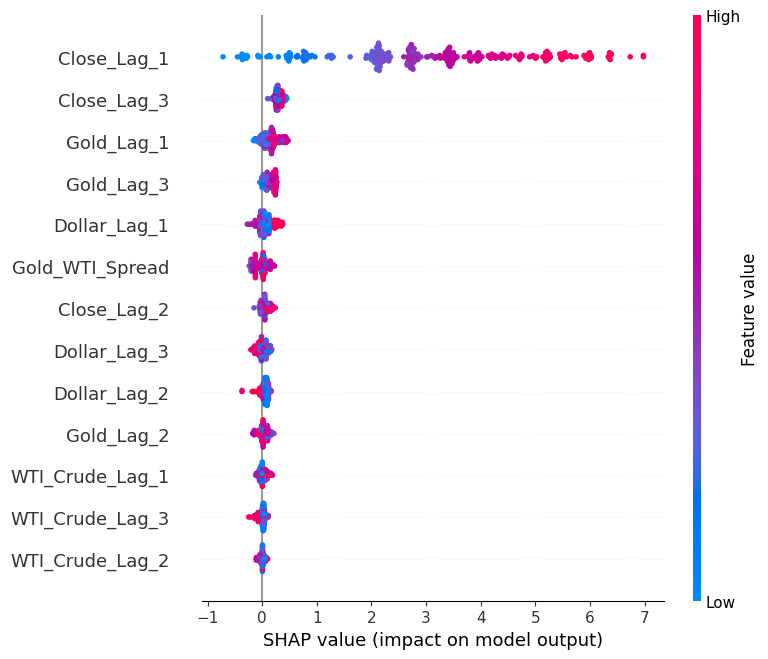

Company DUK MSE: 1.99, R²: 0.81


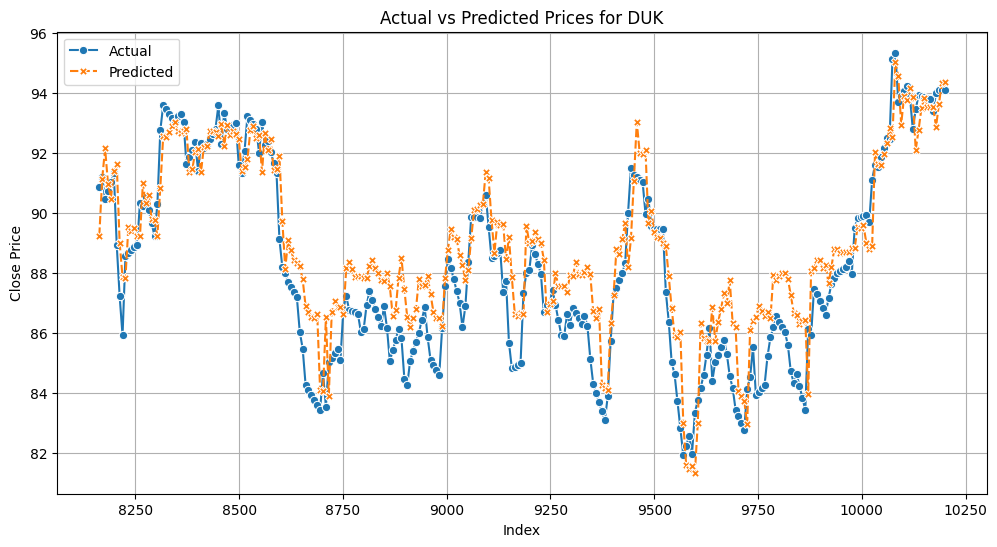

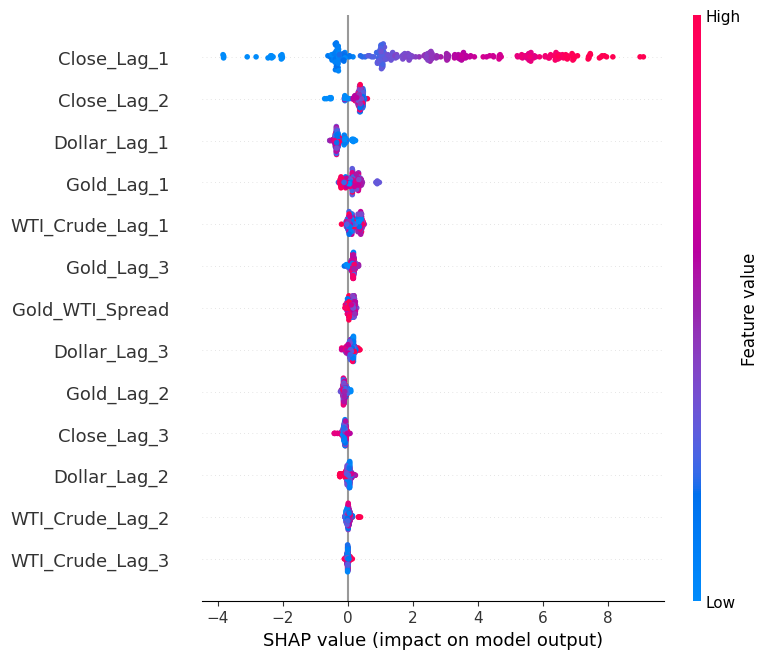

Company JNJ MSE: 2.81, R²: 0.92


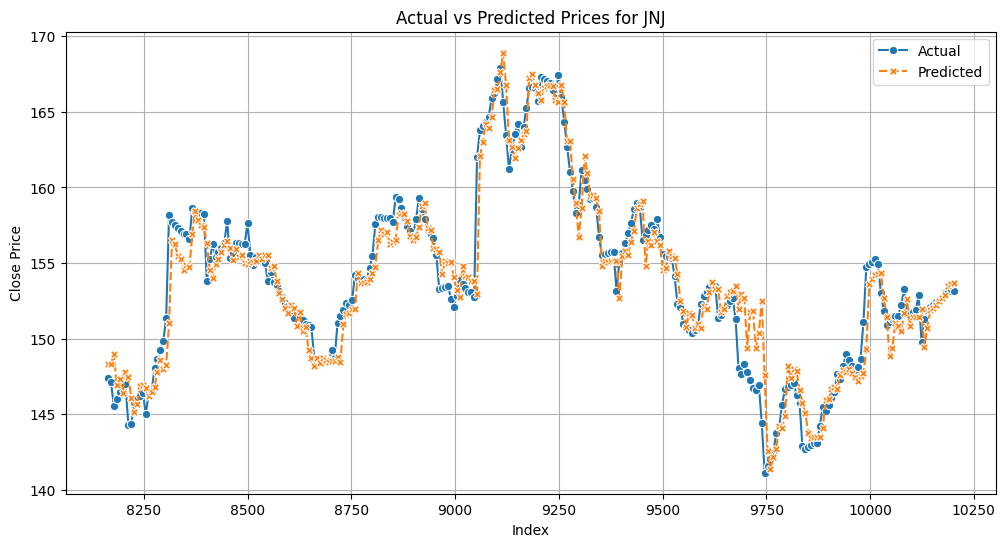

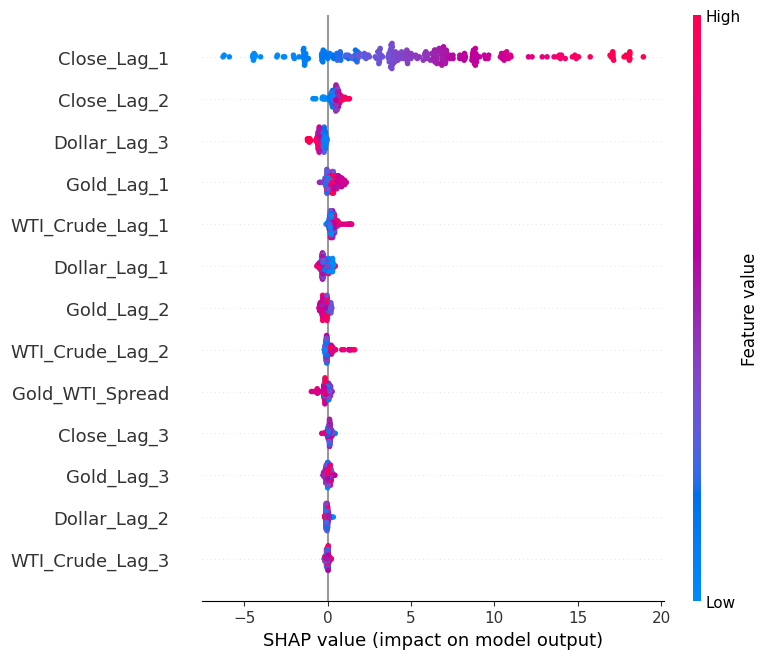

Company JPM MSE: 22.77, R²: 0.79


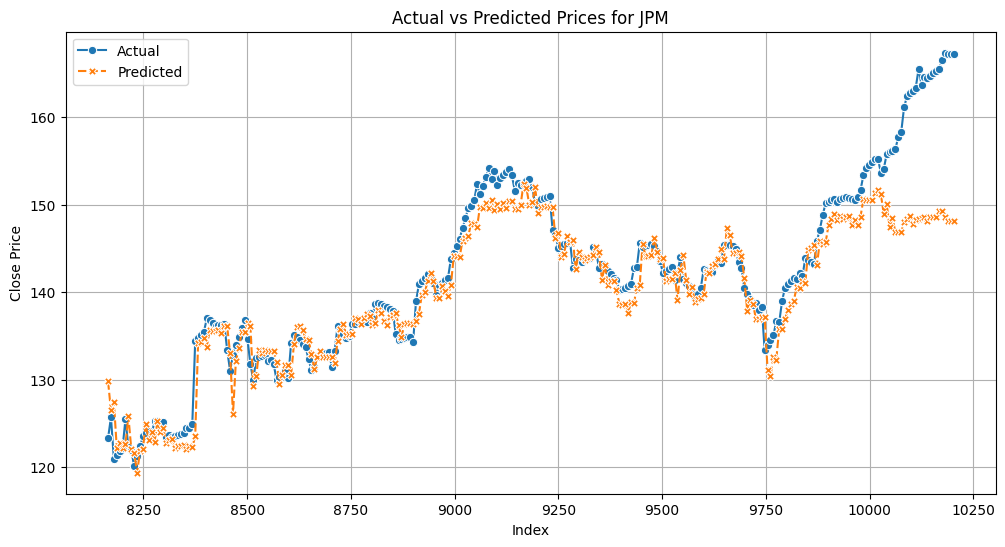

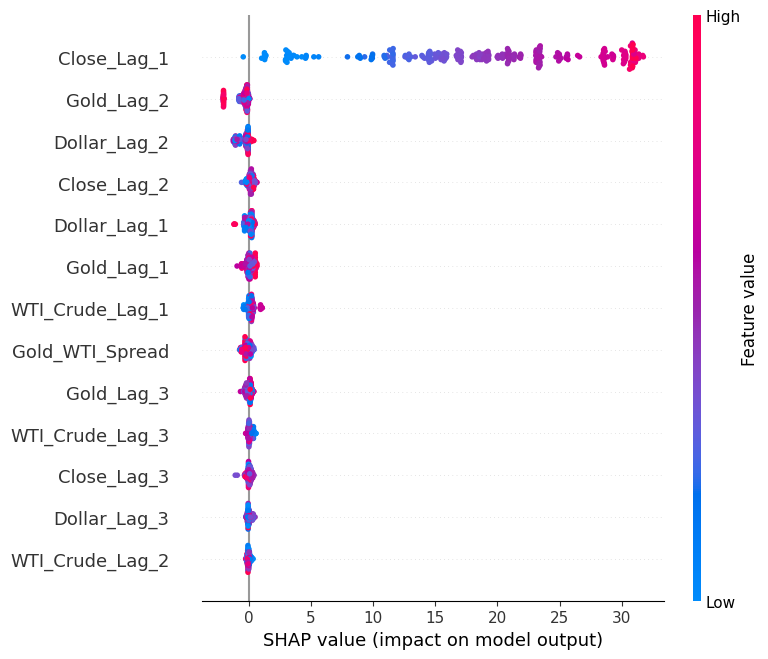

Company TSLA MSE: 48.11, R²: 0.96


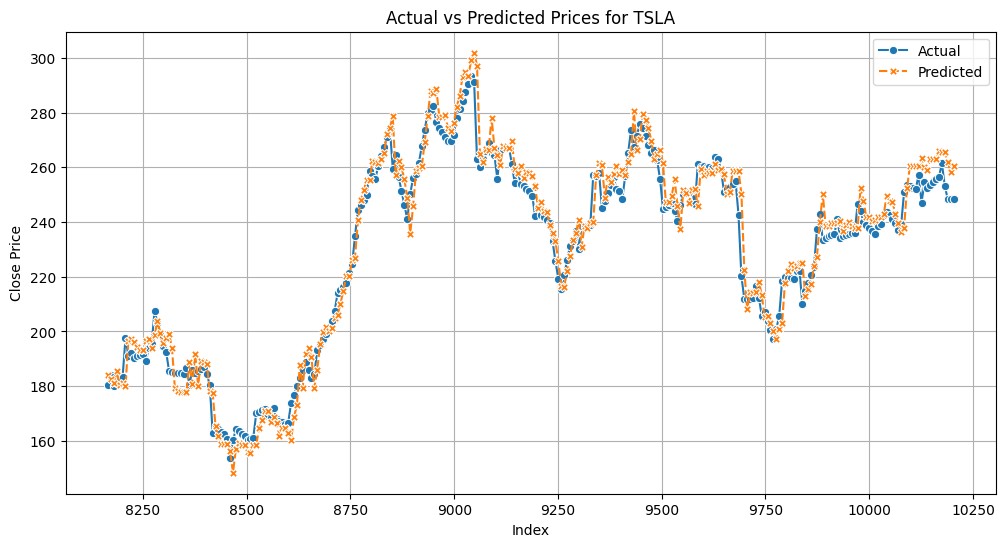

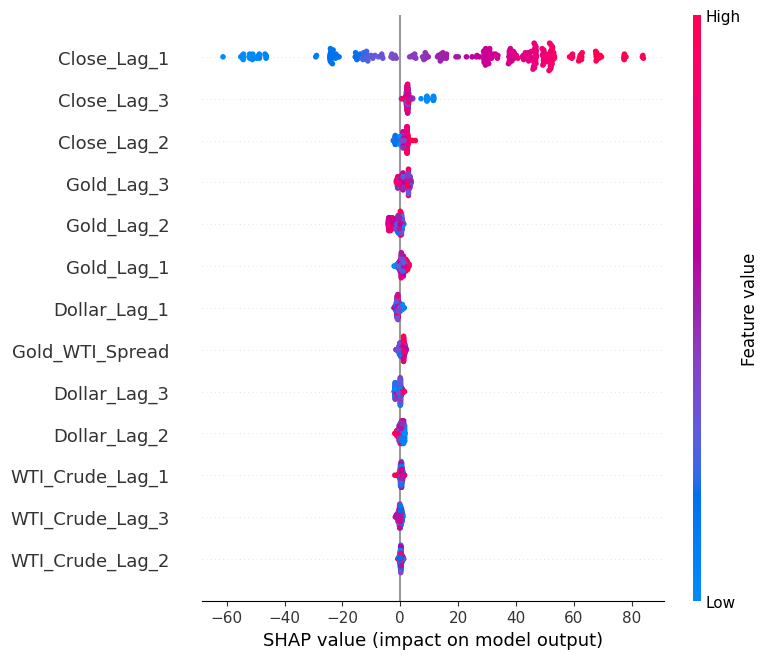

Company VZ MSE: 1.50, R²: 0.63


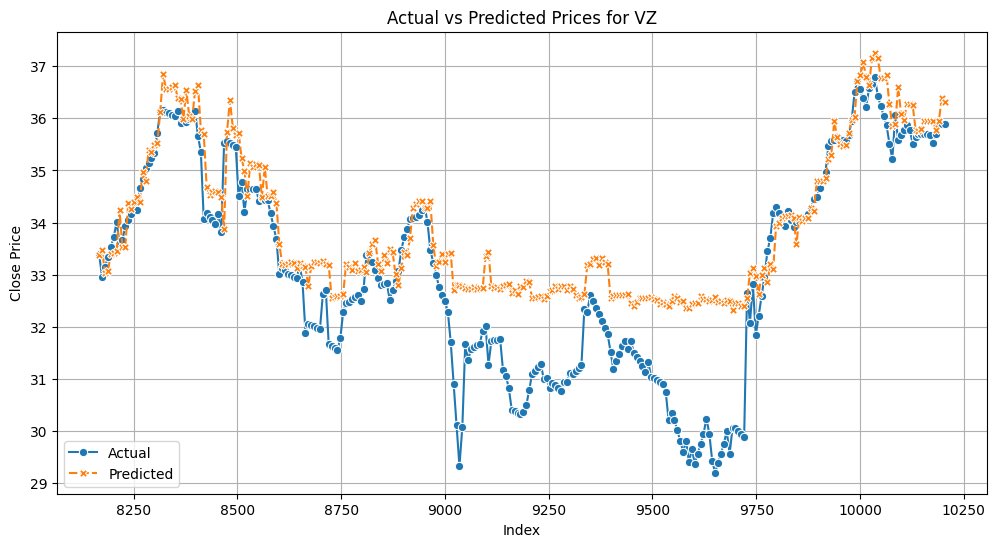

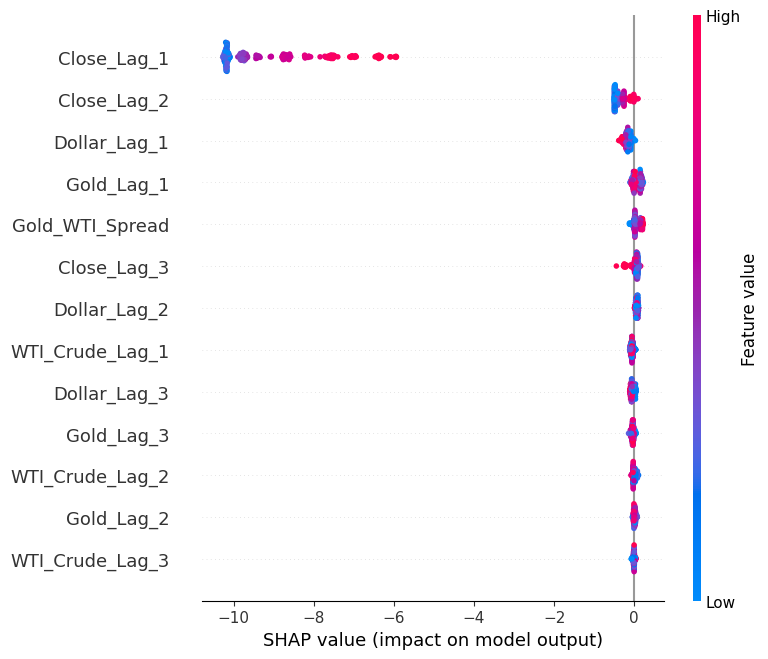

Company XOM MSE: 4.49, R²: 0.80


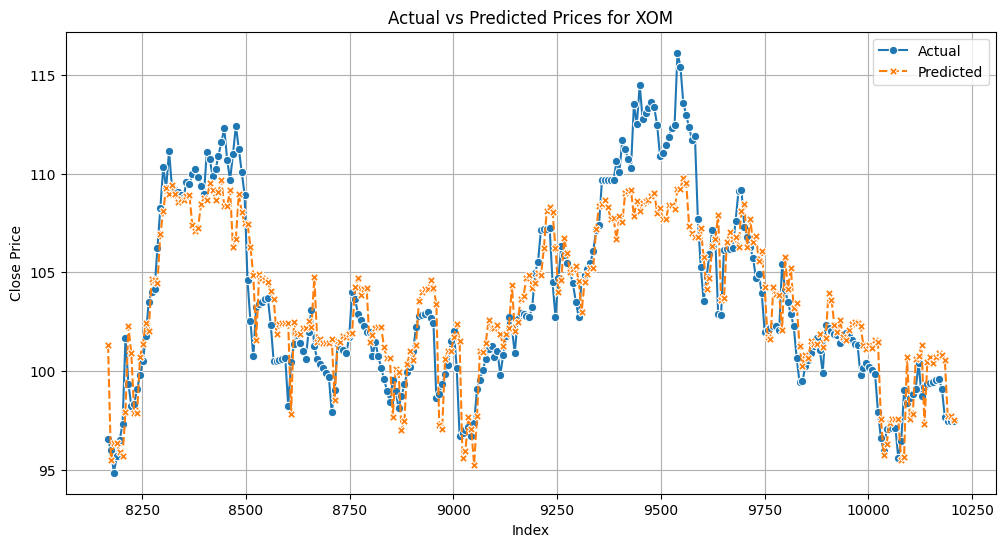

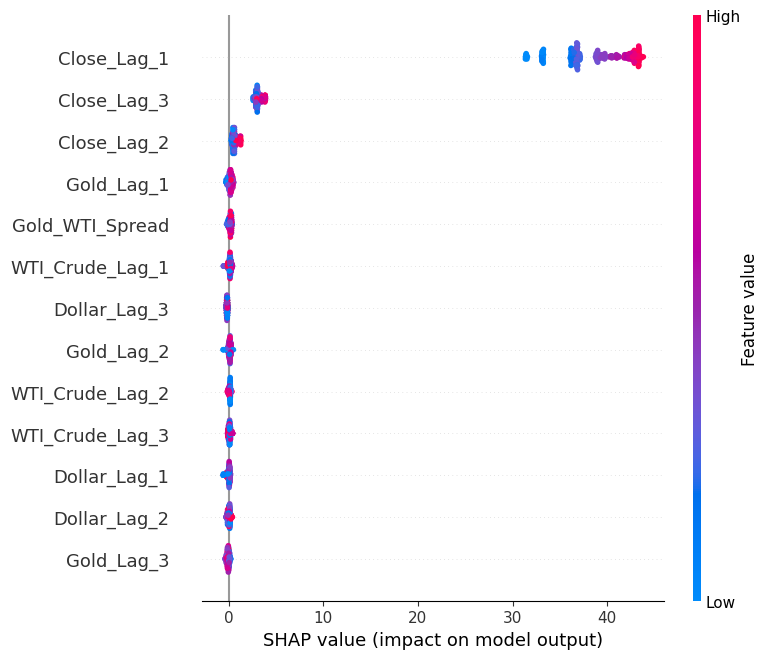

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

company_tickers = df['Ticker'].unique()

for ticker in company_tickers:
    company_data = df[df['Ticker'] == ticker]

    X = company_data.drop(columns=['Close', 'Ticker'])
    y = company_data['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    company_name = ticker_mapping.get(ticker, 'Unknown Company')

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Company {company_name} MSE: {mse:.2f}, R²: {r2:.2f}")

    plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_data, palette="tab10", markers=True)
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs Predicted Prices for {company_name}')
    plt.grid(True)
    plt.show()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)